# Data Wrangling and conversion to GeoJSON format

In [1]:
import os
import re
import pandas as pd
import alphashape
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon

In [2]:
def bounds_for_all_cities():
    directory = "city_data/citypoint"
    dest = "city_data/city_bounds"
    cooling_file = "city_data/City_Cooling.csv"

    os.makedirs(dest, exist_ok=True)
    name_df = pd.read_csv(cooling_file)

    print(f"City_Cooling.csv has {len(name_df)} rows")

    # Create a mapping from GID_1 to city name
    gid_to_name = dict(zip(name_df['GID_1'], name_df.iloc[:, 5]))

    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            match = re.search(r'_(\d{3})\.csv$', filename)

            if not match:
                print(f"Skipping {filename}: No valid GID_1 number found")
                continue

            gid = int(match.group(1))

            if gid not in gid_to_name:
                print(f"Skipping {filename}: GID_1 {gid} not found in City_Cooling.csv")
                continue

            new_name = f"{gid_to_name[gid]}.geojson"
            output_filepath = os.path.join(dest, new_name)

            # Skip if the file already exists
            if os.path.exists(output_filepath):
                print(f"Skipping {new_name}: already exists")
                continue

            df = pd.read_csv(filepath)

            try:
                geometry = get_concave_hull(df)
                geojson = {
                    "type": "FeatureCollection",
                    "features": [
                        {
                            "type": "Feature",
                            "geometry": geometry.__geo_interface__
                        }
                    ]
                }

                with open(output_filepath, "w") as f:
                    json.dump(geojson, f)

                print(f"Saved processed file to {output_filepath}")
            except Exception as e:
                print(f"Error processing {new_name}: {e}")
                continue

In [3]:
bounds_for_all_cities()

City_Cooling.csv has 468 rows
Skipping Aguascalientes, MEX.geojson: already exists
Skipping Cartagena, COL.geojson: already exists
Skipping Cologne, DEU.geojson: already exists
Skipping Cochabamba, BOL.geojson: already exists
Skipping Managua, NIC.geojson: already exists
Skipping Lisboa, PRT.geojson: already exists
Skipping Xiangtan, CHN.geojson: already exists
Skipping Hiroshima, JPN.geojson: already exists
Skipping Zaozhuang, CHN.geojson: already exists
Skipping Rabat, MAR.geojson: already exists
Skipping Addis Ababa, ETH.geojson: already exists
Skipping Yaounde, CMR.geojson: already exists
Skipping Bhopal, IND.geojson: already exists
Skipping Jalandhar, IND.geojson: already exists
Skipping Jamshedpur, IND.geojson: already exists
Skipping Bhubaneswar, IND.geojson: already exists
Skipping N'Djamena, TCD.geojson: already exists
Skipping Mombasa, KEN.geojson: already exists
Skipping Tanger, MAR.geojson: already exists
Skipping Zhangjiakou, CHN.geojson: already exists
Skipping Osaka, JPN

# Processing API calls and TIFF reconnecting

In [2]:
import json
import os
import tempfile
from pathlib import Path
import rasterio
from rasterio.merge import merge
from rasterio.features import geometry_mask
import numpy as np
from shapely.geometry import shape
from sentinelhub import (
    SHConfig,
    SentinelHubRequest, 
    DataCollection, 
    SentinelHubCatalog,
    filter_times,
    MimeType, 
    CRS,
    BBox,
    BBoxSplitter, 
    SentinelHubDownloadClient,
    TileSplitter
)
import getpass
import datetime as dt
import geopandas as gpd
import concurrent.futures
import time
import requests
from rasterio.errors import RasterioIOError

In [3]:
# sh-b029f984-190f-4475-b5c9-8096f4709bb3
# Kh9bYa00XzHzW7i9cOldIXl9iLEdm0MR
config = SHConfig()
config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

Enter your SentinelHub client id ········
Enter your SentinelHub client secret ········


In [4]:
config = SHConfig("cdse")

In [34]:
INPUT_FOLDER = "./selected_cities/"  # Folder containing GeoJSON files
grid = gpd.read_file("s2_tile_grid.geojson")  # Sentinel-2 tile grid

def read_geojson(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def get_mgrs_tiles_from_geojson(aoi_path, tile_grid=grid):
    with open(aoi_path) as f:
        aoi_geojson = json.load(f)
    aoi_geom = shape(aoi_geojson["features"][0]["geometry"])
    aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_geom], crs="EPSG:4326")
    tile_grid = tile_grid.to_crs(aoi_gdf.crs)
    overlapping_tiles = gpd.sjoin(tile_grid, aoi_gdf, predicate="intersects", how="inner")
    return overlapping_tiles  # Return GeoDataFrame

def get_subarea(bbox, NDVI, time_int):
    COLOR_script = """
        //VERSION=3
        function setup() {
          return {
            input: ["B04", "B03", "B02", "dataMask"],
            output: { bands: 4 }
          };
        }
        const maxR = 3.0;
        const midR = 0.13;
        const sat = 1.2;
        const gamma = 1.8;
        function evaluatePixel(smp) {
          const rgbLin = satEnh(sAdj(smp.B04), sAdj(smp.B03), sAdj(smp.B02));
          return [sRGB(rgbLin[0]), sRGB(rgbLin[1]), sRGB(rgbLin[2]), smp.dataMask];
        }
        function sAdj(a) {
          return adjGamma(adj(a, midR, 1, maxR));
        }
        const gOff = 0.01;
        const gOffPow = Math.pow(gOff, gamma);
        const gOffRange = Math.pow(1 + gOff, gamma) - gOffPow;
        function adjGamma(b) {
          return (Math.pow((b + gOff), gamma) - gOffPow) / gOffRange;
        }
        function satEnh(r, g, b) {
          const avgS = (r + g + b) / 3.0 * (1 - sat);
          return [clip(avgS + r * sat), clip(avgS + g * sat), clip(avgS + b * sat)];
        }
        function clip(s) {
          return s < 0 ? 0 : s > 1 ? 1 : s;
        }
        function adj(a, tx, ty, maxC) {
          var ar = clip(a / maxC, 0, 1);
          return ar * (ar * (tx / maxC + ty - 1) - ty) / (ar * (2 * tx / maxC - 1) - tx / maxC);
        }
        const sRGB = (c) => c <= 0.0031308 ? (12.92 * c) : (1.055 * Math.pow(c, 0.41666666666) - 0.055);  
        """

    NVDI_script = '''
        //VERSION=3
        function setup() {
        return {
            input: ["B04", "B08", 'SCL'],
            output: {
                bands: 1,
                sampleType: "FLOAT32"
                }
            };
        }
        function evaluatePixel(samples) {
            const clouds_or_water = [0, 3, 6, 8, 9, 10, 11];
            if (clouds_or_water.includes(samples.SCL)) {
                return [-1]
            }
            return [index(samples.B08, samples.B04)]
        }
        '''

    script = NVDI_script if NDVI else COLOR_script

    # Estimate pixel dimensions at 10m resolution
    width_est = int((bbox.max_x - bbox.min_x) * 111320 / 10)
    height_est = int((bbox.max_y - bbox.min_y) * 110574 / 10)

    scale = min(2500 / width_est, 2500 / height_est, 1.0)
    width = max(1, int(width_est * scale))
    height = max(1, int(height_est * scale))

    return SentinelHubRequest(
        evalscript=script,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url),
                time_interval=time_int,
                mosaicking_order="leastCC",
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=(width, height),
        data_folder=tempfile.gettempdir(),
        config=config,
    )

def catalog(aoi_bbox, time_interval, cloud_cover):
    catalog = SentinelHubCatalog(config=config)
    cloud = f"eo:cloud_cover <= {cloud_cover}"
    search_iterator = catalog.search(
        DataCollection.SENTINEL2_L2A,
        bbox=aoi_bbox,
        time=time_interval,
        filter=cloud,
        fields={"include": ["id", "properties.datetime"], "exclude": []},
    )
    results = list(search_iterator)
    print("Total number of results:", len(results))
    time_difference = dt.timedelta(hours=1)
    all_timestamps = search_iterator.get_timestamps()
    unique_acquisitions = filter_times(all_timestamps, time_difference)
    print("Total number of unique results:", len(unique_acquisitions))
    return unique_acquisitions

MAX_THREADS = 10  # 🔵 Safe limit for SentinelHub free/basic account

def process_geojson_file(file_path, NDVI, time_int, date):
    try:
        geo_json = read_geojson(file_path)
        geom = shape(geo_json["features"][0]["geometry"])
        city_name = Path(file_path).stem
        bbox_splitter = BBoxSplitter([geom], CRS.WGS84, (4, 4))
        bbox_list = bbox_splitter.get_bbox_list()
        
        client = SentinelHubDownloadClient(config=config)
        saved_tiffs_folder = Path("saved_tiffs")
        saved_tiffs_folder.mkdir(exist_ok=True)
        
        # Function to process a single bbox
        def download_one(bbox, max_retries=6, base_delay=1, max_delay=60):
            for attempt in range(max_retries):
                try:
                    sh_request = get_subarea(bbox, NDVI, time_int)
                    dl_request = sh_request.download_list[0]

                    # 🔁 Attempt download via SentinelHub SDK
                    client.download([dl_request], max_threads=1)

                    tiff_path = Path(sh_request.data_folder) / sh_request.get_filename_list()[0]
                    if tiff_path.exists():
                        return rasterio.open(tiff_path)
                    else:
                        print(f"⚠️ File not found after download: {tiff_path}")

                except requests.exceptions.HTTPError as e:
                    retry_after = e.response.headers.get("Retry-After")
                    if retry_after:
                        wait_time = int(retry_after) / 1000
                        print(f"⚠️ HTTP {e.response.status_code} with Retry-After {wait_time:.2f}s")
                    else:
                        wait_time = min(base_delay * (2 ** attempt), max_delay)
                        print(f"⚠️ HTTP {e.response.status_code}. Backoff {wait_time:.2f}s (attempt {attempt+1})")
                    time.sleep(wait_time)
                    continue
                except Exception as e:
                    print(f"⚠️ Error on attempt {attempt+1}: {e}")
                    wait_time = min(base_delay * (2 ** attempt), max_delay)
                    time.sleep(wait_time)

            print(f"❌ Giving up after {max_retries} attempts for bbox: {bbox}")
            return None

        
        tiffs = []
        # 🔵 Use ThreadPoolExecutor to limit concurrency
        with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
            futures = [executor.submit(download_one, bbox) for bbox in bbox_list]
            for future in concurrent.futures.as_completed(futures):
                result = future.result()
                if result:
                    tiffs.append(result)
        
        if not tiffs:
            print(f"⚠️ No valid tiles for {city_name} on {date}")
            return

        mosaic, out_transform = merge(tiffs)
        out_meta = tiffs[0].meta.copy()

        mask = geometry_mask([geom], transform=out_transform, invert=False, out_shape=(mosaic.shape[1], mosaic.shape[2]))

        # ✅ Apply mask to mosaic
        for band in range(mosaic.shape[0]):
            mosaic[band][mask] = np.nan

        out_meta.update({
            "driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_transform,
            "nodata": np.nan
        })

        output_tiff_path = saved_tiffs_folder / f"{city_name}_{date}.tif"
        with rasterio.open(output_tiff_path, "w", **out_meta) as dest:
            dest.write(mosaic)

        for src in tiffs:
            src.close()

        print(f"✔ Merged and masked TIFF saved: {output_tiff_path}")

    except Exception as e:
        print(f"⚠️ Error processing {file_path}: {str(e)}")
# Main loop
geojson_files = [
    os.path.join(INPUT_FOLDER, f)
    for f in os.listdir(INPUT_FOLDER)
    if f.endswith('.geojson')
]

print(f"🔍 Found {len(geojson_files)} GeoJSON files. Processing...")

for year in range(2019, 2025):  # 2025 is excluded
    for file_path in geojson_files:
        geo_json = read_geojson(file_path)
        geom = shape(geo_json["features"][0]["geometry"])
        bbox_tuple = geom.bounds
        bbox = BBox(bbox=bbox_tuple, crs=CRS.WGS84)
        dates = catalog(bbox, (f"{year}-06-01", f"{year}-9-01"), 20)
        time_difference = dt.timedelta(days=2)
        for date in dates:
            process_geojson_file(
                file_path,
                True,
                (date - time_difference, date + time_difference),
                f"{date.date()}"
            )

🔍 Found 1 GeoJSON files. Processing...
Total number of results: 48
Total number of unique results: 18
✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-06-22.tif
✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-06-27.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-06-30.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-07-02.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-07-15.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-07-20.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-07-22.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-07-25.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-07-27.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-07-30.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-08-01.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-08-04.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-08-09.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-08-11.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-08-19.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-08-24.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-08-26.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2019-08-29.tif
Total number of results: 43
Total number of unique results: 17


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-06-01.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-06-09.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-06-14.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-06-21.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-07-04.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-07-06.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-07-14.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-07-19.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-07-21.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-07-29.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-08-03.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-08-05.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-08-10.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-08-20.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-08-25.tif
✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-08-28.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2020-08-30.tif
Total number of results: 29
Total number of unique results: 12


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2021-06-06.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2021-06-09.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2021-06-16.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2021-06-24.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2021-06-29.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2021-07-14.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2021-07-16.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2021-07-21.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2021-07-24.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2021-07-31.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2021-08-13.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2021-08-25.tif
Total number of results: 50
Total number of unique results: 19


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-06-04.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-06-06.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-06-19.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-06-26.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-06-29.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-07-01.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-07-04.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-07-11.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-07-14.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-07-19.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-07-24.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-08-03.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-08-08.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-08-10.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-08-13.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-08-18.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-08-23.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-08-25.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2022-08-30.tif
Total number of results: 71
Total number of unique results: 14


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2023-06-01.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2023-06-06.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2023-07-01.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2023-07-06.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2023-07-11.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2023-07-26.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2023-07-31.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2023-08-05.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2023-08-13.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2023-08-15.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2023-08-18.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2023-08-20.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2023-08-23.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2023-08-30.tif
Total number of results: 38
Total number of unique results: 17


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-06-03.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-06-08.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-06-10.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-06-15.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-06-18.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-06-25.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-06-28.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-07-03.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-07-08.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-07-15.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/d

✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-07-18.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-08-12.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-08-14.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-08-22.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-08-24.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-08-27.tif


/Users/mattleo/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)


✔ Merged and masked TIFF saved: saved_tiffs/New York, United States_2024-08-29.tif


In [2]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [23]:
def view_tiff(file_path, save=True, output_folder="plots/averaged_outputs"):
    # Open the TIFF file
    with rasterio.open(file_path) as src:
        band = src.read(1).astype(float)

        # Mask out NoData or invalid values
        band = np.ma.masked_outside(band, -1, 1)

        # Setup color map
        cmap = plt.cm.RdYlGn
        cmap.set_bad(color="black")

        # Adjust figure size based on image shape
        height, width = band.shape
        fig, ax = plt.subplots(figsize=(width / 300, height / 300), dpi=300)

        im = ax.imshow(band, cmap=cmap, norm=mcolors.Normalize(vmin=-1, vmax=1))
        plt.colorbar(im, ax=ax, label="NDVI Value")
        ax.set_title(f"NDVI TIFF Viewer: {os.path.basename(file_path)}", fontsize=10)
        ax.axis("off")

        if save:
            os.makedirs(output_folder, exist_ok=True)
            out_name = os.path.splitext(os.path.basename(file_path))[0] + ".png"
            out_path = os.path.join(output_folder, out_name)
            plt.savefig(out_path, bbox_inches="tight", pad_inches=0.1, dpi=300)
            print(f"✅ Saved plot: {out_path}")

        plt.close(fig)


In [25]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

class ExponentialNorm(mcolors.Normalize):
    """Custom normalization that compresses high values and stretches low values."""
    def __init__(self, vmin=None, vmax=None, base=np.e, clip=False):
        super().__init__(vmin=vmin, vmax=vmax, clip=clip)
        self.base = base

    def __call__(self, value, clip=None):
        value = np.ma.masked_less_equal(value, 0)
        log_val = np.log(value * (self.base - 1) + 1) / np.log(self.base)
        return super().__call__(log_val, clip)

def view_tiff(file_path, save=True, output_folder="plots/averaged_outputs"):
    # Open the TIFF file
    with rasterio.open(file_path) as src:
        band = src.read(1).astype(float)

        # Mask values <= 0
        band = np.ma.masked_less_equal(band, 0)

        # Normalize range based on unmasked data
        vmax = band.max() if not np.ma.is_masked(band) else band.compressed().max()
        norm = ExponentialNorm(vmin=0.001, vmax=vmax, base=5)  # base > 1 for more curve

        # Create red-yellow-green colormap
        cmap = mcolors.LinearSegmentedColormap.from_list("custom_rgy", ["red", "yellow", "green"])
        cmap.set_bad(color="black")
        cmap.set_under(color="black")

        # Adjust figure size
        height, width = band.shape
        fig, ax = plt.subplots(figsize=(width / 300, height / 300), dpi=300)

        # Plot image
        im = ax.imshow(band, cmap=cmap, norm=norm)
        plt.colorbar(im, ax=ax, label="Value")
        ax.set_title(f"TIFF Viewer: {os.path.basename(file_path)}", fontsize=10)
        ax.axis("off")

        # Save the plot
        if save:
            os.makedirs(output_folder, exist_ok=True)
            out_name = os.path.splitext(os.path.basename(file_path))[0] + ".png"
            out_path = os.path.join(output_folder, out_name)
            plt.savefig(out_path, bbox_inches="tight", pad_inches=0.1, dpi=300)
            print(f"✅ Saved plot: {out_path}")

        plt.close(fig)


In [26]:
TIFF_FOLDER = "./saved_tiffs/outputs_weighted"

tiff_files = [
    os.path.join(TIFF_FOLDER, f)
    for f in os.listdir(TIFF_FOLDER)
    if f.endswith(".tif")
]

print(f"🔍 Found {len(tiff_files)} TIFF files. Processing...")

for file_path in tiff_files:
    view_tiff(file_path)

🔍 Found 10 TIFF files. Processing...


/var/folders/lk/r34gnvg90_jfwsmf_vlk1q_80000gn/T/ipykernel_52845/2978426125.py:15: RuntimeWarning: invalid value encountered in log
  log_val = np.log(value * (self.base - 1) + 1) / np.log(self.base)
/var/folders/lk/r34gnvg90_jfwsmf_vlk1q_80000gn/T/ipykernel_52845/2978426125.py:15: RuntimeWarning: divide by zero encountered in log
  log_val = np.log(value * (self.base - 1) + 1) / np.log(self.base)


✅ Saved plot: plots/averaged_outputs/Copenhagen, Denmark_average.png
✅ Saved plot: plots/averaged_outputs/Pune, India_average.png
✅ Saved plot: plots/averaged_outputs/Lima, Peru_average.png
✅ Saved plot: plots/averaged_outputs/Singapore_average.png
✅ Saved plot: plots/averaged_outputs/Nairobi, Kenya_average.png
✅ Saved plot: plots/averaged_outputs/New York, United States_average.png
✅ Saved plot: plots/averaged_outputs/Jakarta, Indonesia_average.png
✅ Saved plot: plots/averaged_outputs/Bogota, Colombia_average.png
✅ Saved plot: plots/averaged_outputs/Berlin, Germany_average.png
✅ Saved plot: plots/averaged_outputs/Malmö, Sweden_average.png


# Statistics

In [42]:
def compute_ndvi_stats_from_geojson(tiff_path, geojson_path):
    import numpy as np
    import rasterio
    import geopandas as gpd
    from rasterio.mask import mask
    from shapely.geometry import mapping
    import os

    # Load GeoJSON
    gdf = gpd.read_file(geojson_path)

    # Open TIFF to get CRS and nodata
    with rasterio.open(tiff_path) as src:
        tiff_crs = src.crs
        nodata = src.nodata

    # Reproject GeoJSON to match TIFF CRS
    if gdf.crs != tiff_crs:
        gdf = gdf.to_crs(tiff_crs)

    # Calculate total area in km² (handles multipolygons too)
    area_km2 = gdf.to_crs(epsg=3857).geometry.area.sum() / 1e6

    # Convert geometry to GeoJSON-style dicts for masking
    geometry_list = [mapping(geom) for geom in gdf.geometry]

    # Apply raster mask
    with rasterio.open(tiff_path) as src:
        try:
            out_image, _ = mask(src, geometry_list, crop=True)
        except ValueError as e:
            print(f"❌ {os.path.basename(tiff_path)} skipped — {e}")
            return None

    ndvi = out_image[0].astype('float32')
    ndvi = np.where((ndvi <= 0) | (ndvi == nodata), np.nan, ndvi)

    # NDVI statistics
    mean_ndvi = np.nanmean(ndvi)
    valid_pixels = np.count_nonzero(~np.isnan(ndvi))
    vegetated_pixels = np.count_nonzero(ndvi > 0.6)
    vegetation_pct = 100 * vegetated_pixels / valid_pixels if valid_pixels > 0 else np.nan

    print(f"📍 {os.path.basename(tiff_path)}")
    print(f"   - Mean NDVI (> 0):           {mean_ndvi:.4f}")
    print(f"   - Valid Pixels:              {valid_pixels}")
    print(f"   - Dense Veg. Pixels (>0.6):  {vegetated_pixels}")
    print(f"   - Dense Veg. Coverage (%):   {vegetation_pct:.2f}%")
    print(f"   - Area (km²):                {area_km2:.2f}\n")

    return mean_ndvi, valid_pixels, vegetation_pct


In [43]:
import os

# Data folders
TIFF_DIR = "./saved_tiffs/outputs_weighted"
GEOJSON_DIR = "./selected_cities"

def get_base_city_name(filename):
    """Extract base city name without extension or trailing date."""
    return os.path.splitext(filename)[0].split("_")[0]

# List files
tiff_files = [f for f in os.listdir(TIFF_DIR) if f.endswith(".tif")]
geojson_files = [f for f in os.listdir(GEOJSON_DIR) if f.endswith(".geojson")]

# Map cities to files
tiff_map = {get_base_city_name(f): os.path.join(TIFF_DIR, f) for f in tiff_files}
geojson_map = {os.path.splitext(f)[0]: os.path.join(GEOJSON_DIR, f) for f in geojson_files}

# Match TIFF and GeoJSON by city name
matched_files = [
    (tiff_path, geojson_map[city])
    for city, tiff_path in tiff_map.items()
    if city in geojson_map
]

print(f"🔗 Matched {len(matched_files)} TIFF–GeoJSON city pairs.\n")

# Compute NDVI stats for each matched pair
for tiff_path, geojson_path in matched_files:
    compute_ndvi_stats_from_geojson(tiff_path, geojson_path)


🔗 Matched 10 TIFF–GeoJSON city pairs.

📍 Copenhagen, Denmark_average.tif
   - Mean NDVI (> 0):           0.0839
   - Valid Pixels:              1318628
   - Dense Veg. Pixels (>0.6):  10
   - Dense Veg. Coverage (%):   0.00%
   - Area (km²):                288.25

📍 Pune, India_average.tif
   - Mean NDVI (> 0):           0.0846
   - Valid Pixels:              2923558
   - Dense Veg. Pixels (>0.6):  2
   - Dense Veg. Coverage (%):   0.00%
   - Area (km²):                349.20

📍 Lima, Peru_average.tif
   - Mean NDVI (> 0):           0.0171
   - Valid Pixels:              8023994
   - Dense Veg. Pixels (>0.6):  0
   - Dense Veg. Coverage (%):   0.00%
   - Area (km²):                2993.49

📍 Singapore_average.tif
   - Mean NDVI (> 0):           0.0603
   - Valid Pixels:              3721278
   - Dense Veg. Pixels (>0.6):  324
   - Dense Veg. Coverage (%):   0.01%
   - Area (km²):                1735.11

📍 Nairobi, Kenya_average.tif
   - Mean NDVI (> 0):           0.0734
   - Valid Pixe

In [35]:
import os
import re
import numpy as np
import rasterio
from rasterio.enums import Resampling
from collections import defaultdict
from glob import glob

def process_saved_tifs(folder_path="saved_tiffs"):
    # Group files by city-country
    city_country_files = defaultdict(list)
    
    for file_path in glob(os.path.join(folder_path, "*.tif")):
        filename = os.path.basename(file_path)
        # Split at the last underscore
        if "_" in filename:
            city_country_part = filename.rsplit("_", 1)[0]  # everything before last underscore
            city_country_files[city_country_part].append(file_path)
    
    # Output folder
    output_folder = os.path.join(folder_path, "averaged_outputs")
    os.makedirs(output_folder, exist_ok=True)

    for city_country, files in city_country_files.items():
        print(f"Processing {city_country} with {len(files)} files...")
        
        # Read all the datasets
        datasets = [rasterio.open(f) for f in files]
        
        # Assume all rasters have the same shape/crs/transform
        meta = datasets[0].meta.copy()
        meta.update(dtype='float32', count=1)  # Single band output
        
        # Read all into arrays
        arrays = []
        for ds in datasets:
            arr = ds.read(1).astype(np.float32)
            arrays.append(arr)
        
        arrays = np.stack(arrays)  # Shape (n_files, height, width)
        
        # Mask out invalid values (<0)
        valid_mask = arrays >= -0.5
        
        # Sum of valid pixels
        sum_pixels = np.where(valid_mask, arrays, 0).sum(axis=0)
        
        # Count of valid observations
        count_pixels = valid_mask.sum(axis=0)
        
        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            average_pixels = np.where(count_pixels > 0, sum_pixels / count_pixels, np.nan)
        
        # Save the averaged image
        output_path = os.path.join(output_folder, f"{city_country}_average.tif")
        
        # Update metadata to allow transparency via nodata
        meta.update(nodata=np.nan)

        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(average_pixels, 1)
        
        # Close datasets
        for ds in datasets:
            ds.close()
    
    print("✅ Finished processing all cities.")
    
process_saved_tifs()

Processing Pune, India with 57 files...
Processing Malmö, Sweden with 56 files...
Processing Jakarta, Indonesia with 67 files...
Processing New York, United States with 144 files...
Processing Bogota, Colombia with 9 files...
Processing Singapore with 33 files...
Processing Nairobi, Kenya with 16 files...
Processing Lima, Peru with 23 files...
Processing Copenhagen, Denmark with 56 files...
Processing Berlin, Germany with 15 files...
✅ Finished processing all cities.


- Get the geojsons for cities
- Adapt the data pulling func to not be concurrent 
- Average the values over a 2 month time period
- Make that graph of per pixel
- Do the statistics on those averages

- choose growing month per city
- avg over 5 years
- get the governmental bounds
- use cc cut off to make sure data is good
- gather all tifs to create a single visualization

HAVE TO RECREATE TILE BASED METHOD BC ITS NOT AVAILABLE FOR FREE

# Density Account

In [17]:
import os
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import mapping
from shapely.ops import unary_union
import numpy as np

# Paths
input_dir = "selected_cities"
output_dir = "saved_tiffs/density"
globe_tif = "globe.tif"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

print(f"Opening {globe_tif}...")
with rasterio.open(globe_tif) as src:
    globe_crs = src.crs
    globe_nodata = src.nodata

    for geojson_file in os.listdir(input_dir):
        if not geojson_file.endswith(".geojson"):
            continue

        geojson_path = os.path.join(input_dir, geojson_file)
        print(f"\n📍 Processing city: {geojson_file}")
        gdf = gpd.read_file(geojson_path)
        gdf = gdf.to_crs(globe_crs)

        # Union all geometries
        union_geom = unary_union(gdf.geometry)
        geometry_mask = [mapping(union_geom)]

        # Initial mask to get extent and values
        out_image, out_transform = mask(src, geometry_mask, crop=True)
        combined = out_image[0].astype(np.float32)

        print(f"Initial masked shape: {combined.shape}")

        # Set all values outside polygon to 0
        combined_mask = mask(src, geometry_mask, crop=True, filled=False)[0].mask[0]
        combined[combined_mask] = 0
        combined = combined / 10000

        # # Logarithmic normalization (log10(value) / 4.0)
        # nonzero_mask = combined > 0
        # combined_log = np.zeros_like(combined, dtype=np.float32)
        # combined_log[nonzero_mask] = np.log10(combined[nonzero_mask]) / 4.0
        # combined_log = np.clip(combined_log, 0.0, 1.0)

        print("✔ Log normalization applied.")

        # Reproject to EPSG:4326
        dst_crs = "EPSG:4326"
        dst_transform, width, height = calculate_default_transform(
            globe_crs, dst_crs, combined.shape[1], combined.shape[0], *union_geom.bounds
        )
        dst_data = np.empty((height, width), dtype=combined.dtype)

        print("🌐 Reprojecting to EPSG:4326...")
        reproject(
            source=combined,
            destination=dst_data,
            src_transform=out_transform,
            src_crs=globe_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

        # Save the final TIFF
        output_path = os.path.join(output_dir, f"{os.path.splitext(geojson_file)[0]}.tif")
        print(f"💾 Saving to {output_path}...")

        with rasterio.open(
            output_path, "w",
            driver="GTiff",
            height=dst_data.shape[0],
            width=dst_data.shape[1],
            count=1,
            dtype="float32",
            crs=dst_crs,
            transform=dst_transform,
            nodata=0
        ) as dst:
            dst.write(dst_data, 1)

        print(f"✅ Finished {geojson_file}")

print("\n🎉 All cities processed.")


Opening globe.tif...

📍 Processing city: Berlin, Germany.geojson
Initial masked shape: (348, 493)
✔ Log normalization applied.
🌐 Reprojecting to EPSG:4326...
💾 Saving to saved_tiffs/density/Berlin, Germany.tif...
✅ Finished Berlin, Germany.geojson

📍 Processing city: New York, United States.geojson
Initial masked shape: (493, 653)
✔ Log normalization applied.
🌐 Reprojecting to EPSG:4326...
💾 Saving to saved_tiffs/density/New York, United States.tif...
✅ Finished New York, United States.geojson

📍 Processing city: Malmö, Sweden.geojson
Initial masked shape: (105, 147)
✔ Log normalization applied.
🌐 Reprojecting to EPSG:4326...
💾 Saving to saved_tiffs/density/Malmö, Sweden.tif...
✅ Finished Malmö, Sweden.geojson

📍 Processing city: Nairobi, Kenya.geojson
Initial masked shape: (352, 442)
✔ Log normalization applied.
🌐 Reprojecting to EPSG:4326...
💾 Saving to saved_tiffs/density/Nairobi, Kenya.tif...
✅ Finished Nairobi, Kenya.geojson

📍 Processing city: Lima, Peru.geojson
Initial masked

In [15]:
import rasterio
import numpy as np

with rasterio.open("saved_tiffs/density/New York, United States.tif") as src:
    data = src.read(1)
    data = data[data != 0]  # exclude background/no-data if you masked it to 0
    print("Min:", np.min(data))
    print("Max:", np.max(data))
    print("Mean:", np.mean(data))


Min: 1e-04
Max: 0.9791
Mean: 0.29711846


In [18]:
import os
import rasterio
import numpy as np
from rasterio.enums import Resampling
from rasterio.warp import reproject

input_dir = "saved_tiffs/averaged_outputs"
density_dir = "saved_tiffs/density"
output_dir = "saved_tiffs/outputs_weighted"

os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if not filename.endswith("_average.tif"):
        continue

    base_name = filename.replace("_average.tif", "")
    density_path = os.path.join(density_dir, f"{base_name}.tif")
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    if not os.path.exists(density_path):
        print(f"Density file missing for {filename}, skipping.")
        continue

    with rasterio.open(input_path) as avg_src:
        avg_data = avg_src.read(1).astype(np.float32)
        avg_profile = avg_src.profile
        target_shape = avg_src.shape
        target_transform = avg_src.transform
        target_crs = avg_src.crs

    with rasterio.open(density_path) as dens_src:
        dens_data = dens_src.read(1).astype(np.float32)
        dens_transform = dens_src.transform
        dens_crs = dens_src.crs

        dens_resampled = np.empty_like(avg_data, dtype=np.float32)

        reproject(
            source=dens_data,
            destination=dens_resampled,
            src_transform=dens_transform,
            src_crs=dens_crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            dst_shape=target_shape,
            resampling=Resampling.nearest
        )

    weighted_data = avg_data * dens_resampled
    weighted_data[~np.isfinite(weighted_data)] = 0

    with rasterio.open(output_path, 'w', **avg_profile) as dst:
        dst.write(weighted_data, 1)

    print(f"✅ Saved weighted output to {output_path}")


✅ Saved weighted output to saved_tiffs/outputs_weighted/Copenhagen, Denmark_average.tif
✅ Saved weighted output to saved_tiffs/outputs_weighted/Pune, India_average.tif
✅ Saved weighted output to saved_tiffs/outputs_weighted/Lima, Peru_average.tif
✅ Saved weighted output to saved_tiffs/outputs_weighted/Singapore_average.tif
✅ Saved weighted output to saved_tiffs/outputs_weighted/Nairobi, Kenya_average.tif
✅ Saved weighted output to saved_tiffs/outputs_weighted/New York, United States_average.tif
✅ Saved weighted output to saved_tiffs/outputs_weighted/Jakarta, Indonesia_average.tif
✅ Saved weighted output to saved_tiffs/outputs_weighted/Bogota, Colombia_average.tif
✅ Saved weighted output to saved_tiffs/outputs_weighted/Berlin, Germany_average.tif
✅ Saved weighted output to saved_tiffs/outputs_weighted/Malmö, Sweden_average.tif


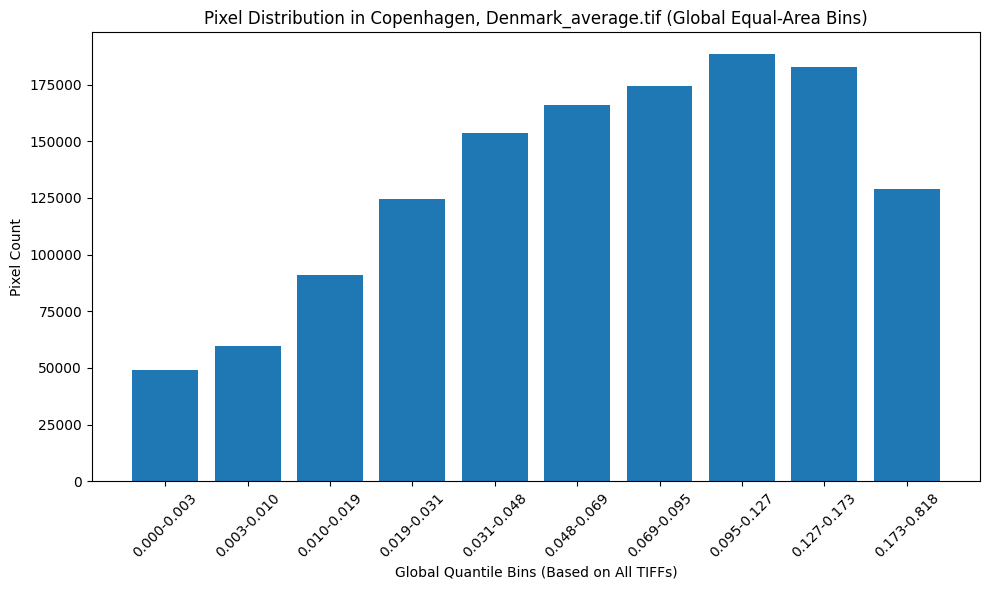

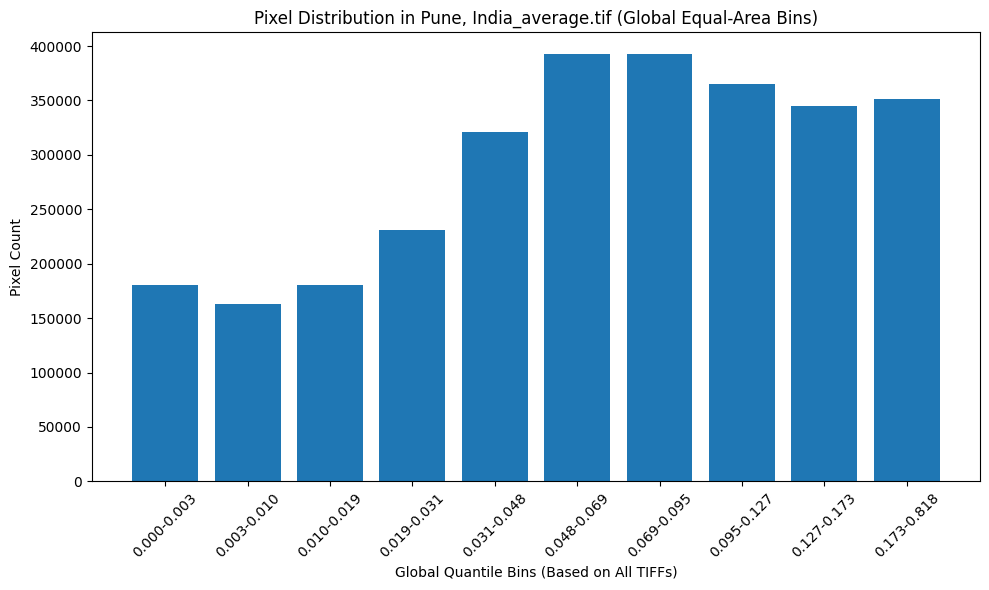

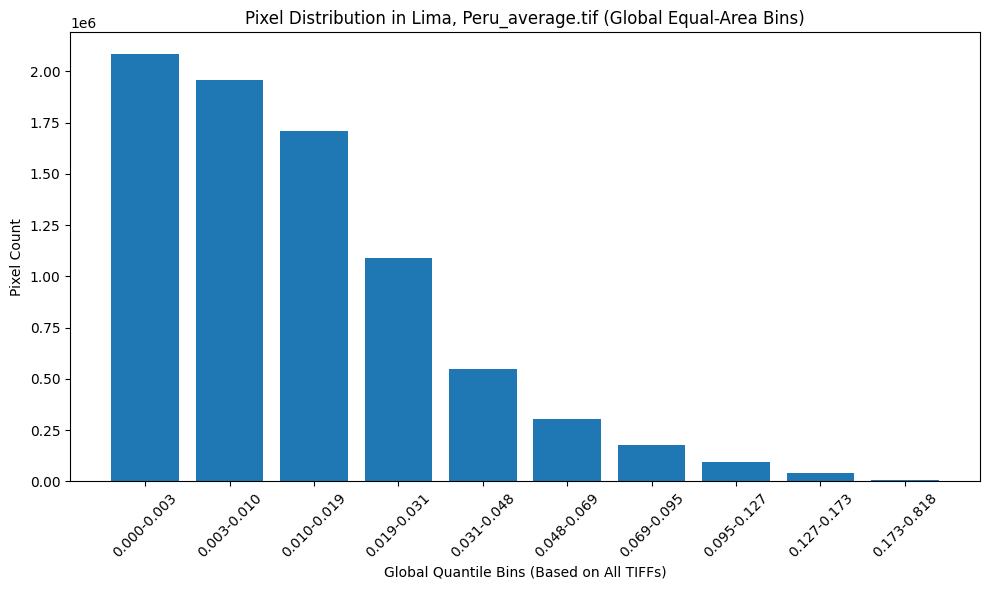

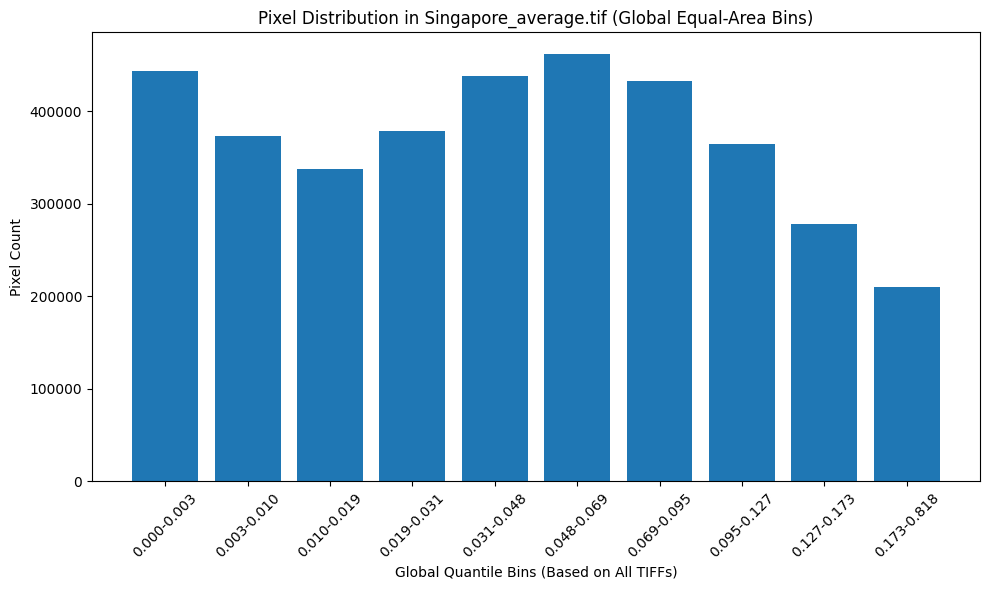

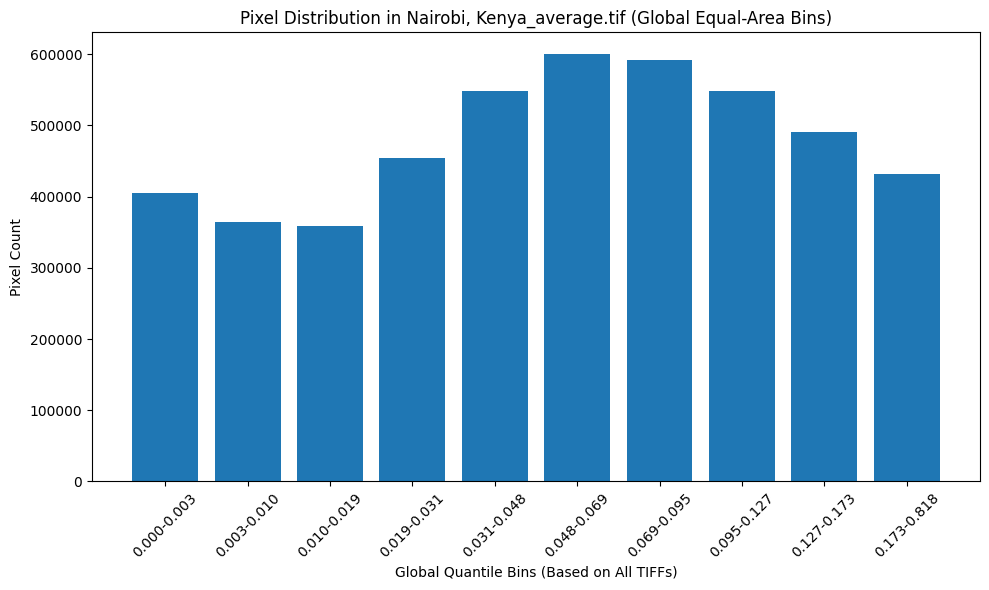

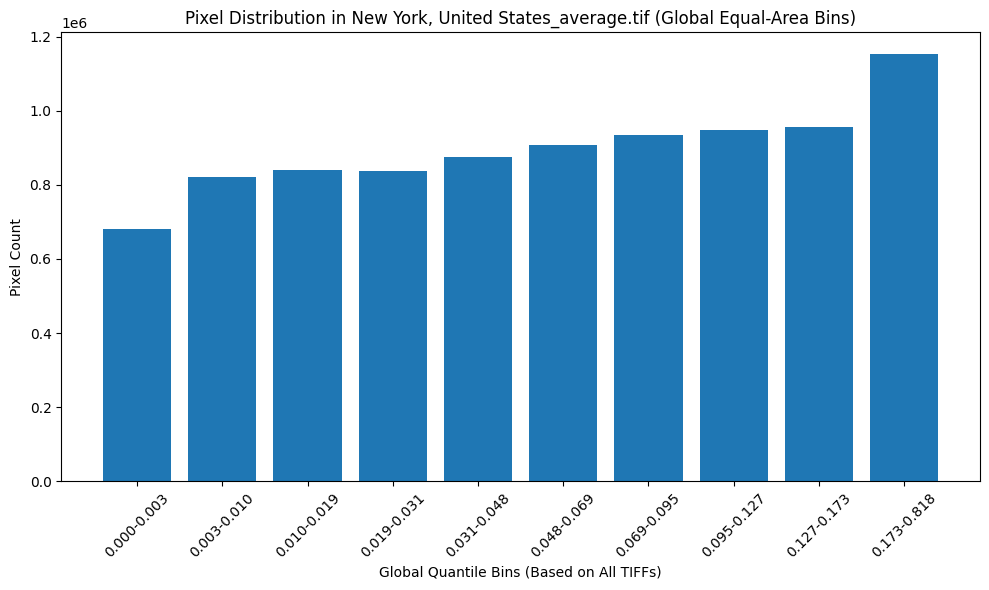

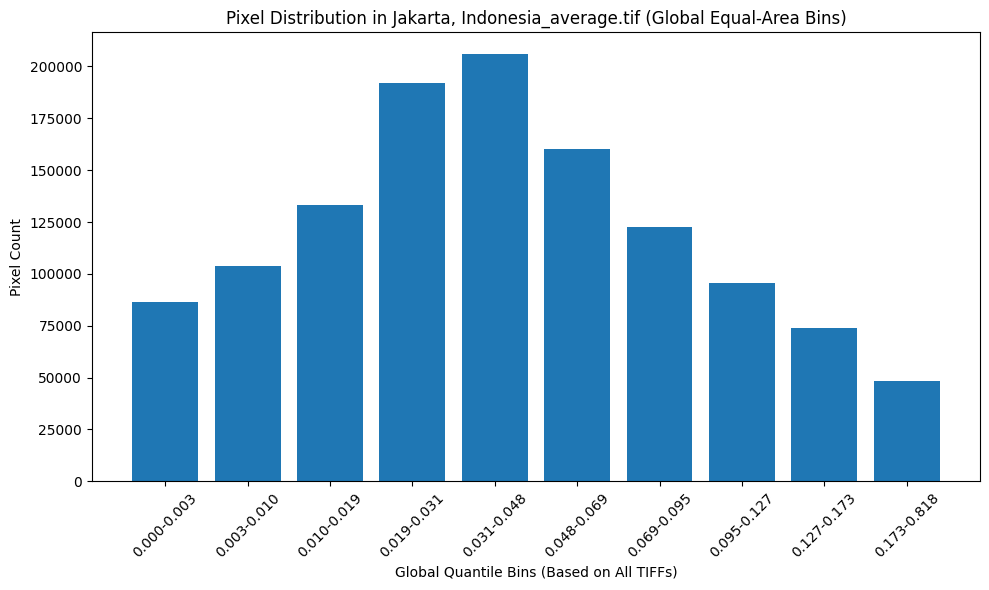

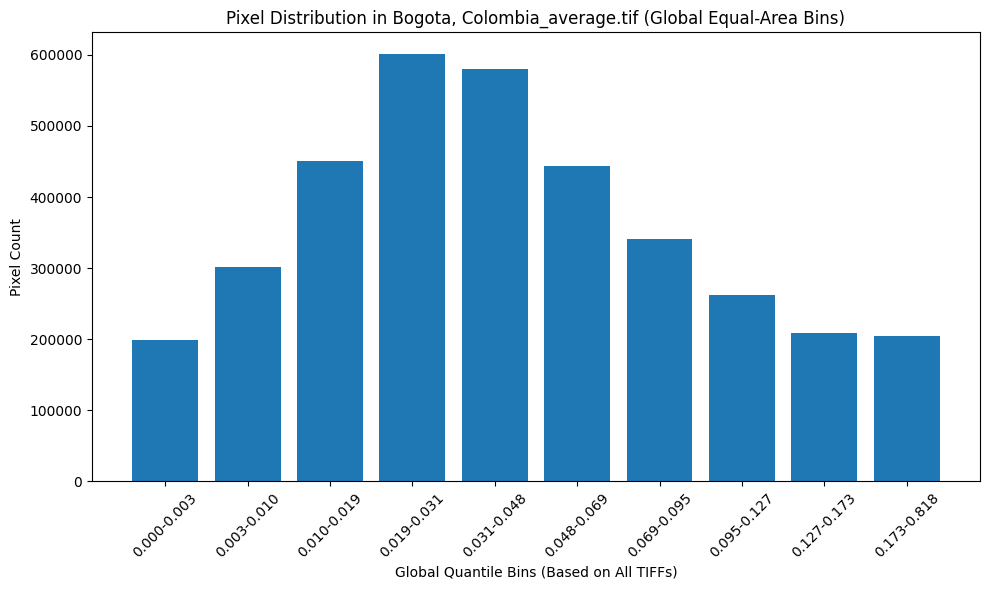

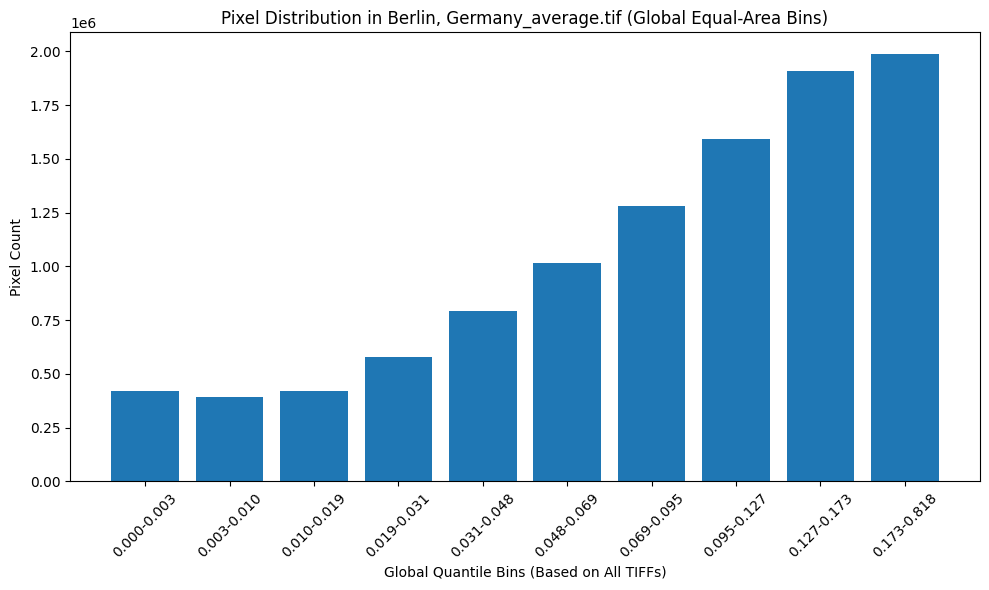

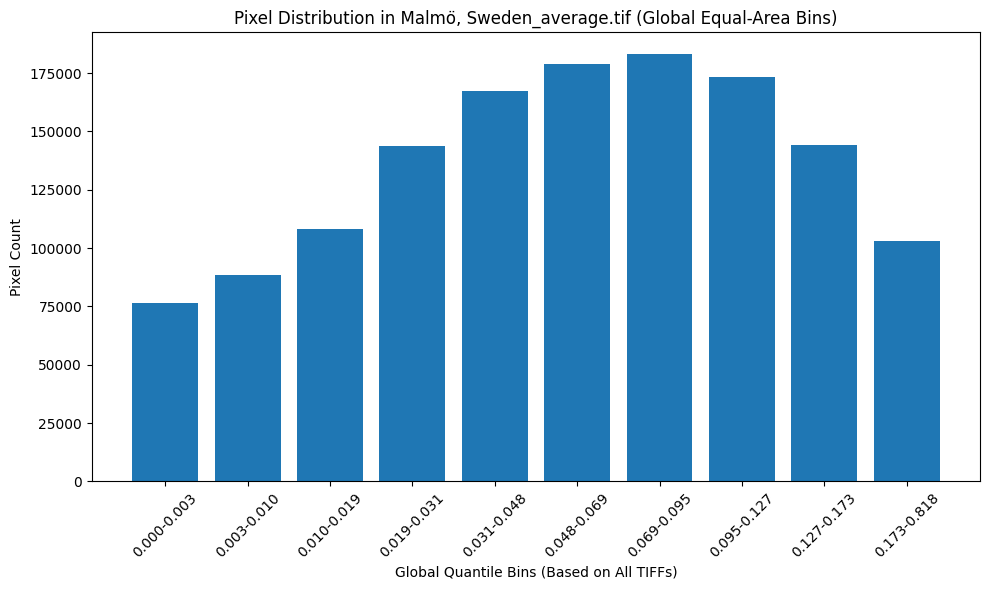

In [24]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

output_dir = "saved_tiffs/outputs_weighted"
num_bins = 10
all_values = []

# First pass: gather all pixel values across TIFFs
for filename in os.listdir(output_dir):
    if not filename.endswith(".tif"):
        continue
    file_path = os.path.join(output_dir, filename)
    with rasterio.open(file_path) as src:
        data = src.read(1).astype(np.float32)
        data = data[np.isfinite(data)]
        data = data[data > 0]  # Optionally ignore zeros
        all_values.append(data)

# Combine all values and compute global quantile bins
all_data = np.concatenate(all_values)
all_data = np.clip(all_data, 0, 1)
global_quantile_edges = np.quantile(all_data, np.linspace(0, 1, num_bins + 1))
bin_labels = [f"{global_quantile_edges[i]:.3f}-{global_quantile_edges[i+1]:.3f}" for i in range(num_bins)]

# Second pass: plot each TIFF's histogram using global bins
for filename in os.listdir(output_dir):
    if not filename.endswith(".tif"):
        continue
    file_path = os.path.join(output_dir, filename)
    with rasterio.open(file_path) as src:
        data = src.read(1).astype(np.float32)
        data = data[np.isfinite(data)]
        data = data[data > 0]
        data = np.clip(data, 0, 1)

    counts, _ = np.histogram(data, bins=global_quantile_edges)

    plt.figure(figsize=(10, 6))
    plt.bar(range(num_bins), counts, tick_label=bin_labels, width=0.8)
    plt.xticks(rotation=45)
    plt.xlabel("Global Quantile Bins (Based on All TIFFs)")
    plt.ylabel("Pixel Count")
    plt.title(f"Pixel Distribution in {filename} (Global Equal-Area Bins)")
    plt.tight_layout()
    plt.show()  # Or save with plt.savefig(...)


In [9]:
print(f"Input CRS: {src.crs}")
print(f"Globe CRS: {globe.crs}")

Input CRS: EPSG:4326
Globe CRS: ESRI:54009


# Tile Processing

In [13]:
import geopandas as gpd
from shapely.geometry import shape
import json

def get_mgrs_tiles_from_geojson(aoi_path, tile_grid_path="s2_tile_grid.geojson"):
    # Load the Sentinel-2 tile grid
    tile_grid = gpd.read_file(tile_grid_path)

    # Load AOI geometry from a GeoJSON file
    with open(aoi_path) as f:
        aoi_geojson = json.load(f)
    aoi_geom = shape(aoi_geojson["features"][0]["geometry"])
    aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_geom], crs="EPSG:4326")

    # Ensure same CRS
    tile_grid = tile_grid.to_crs(aoi_gdf.crs)

    # Spatial join to find overlapping tiles
    overlapping_tiles = gpd.sjoin(tile_grid, aoi_gdf, predicate="intersects", how="inner")

    # Get unique MGRS tile names
    tile_ids = overlapping_tiles["name"].unique().tolist()
    return tile_ids


In [ ]:
tile_ids = get_mgrs_tiles_from_geojson("selected_cities/Jakarta, Indonesia.geojson")
print("Overlapping tiles:", tile_ids)